In [1]:
# %load train_agent.py
from __future__ import print_function

import pickle
import numpy as np
import os
import gzip
import matplotlib.pyplot as plt

from model import Model
from utils import *
from tensorboard_evaluation import Evaluation
import tensorflow as tf

def read_data(datasets_dir="./data", frac = 0.1):
    """
    This method reads the states and actions recorded in drive_manually.py 
    and splits it into training/ validation set.
    """
    print("... read data")
    data_file = os.path.join(datasets_dir, 'data.pkl.gzip')
  
    f = gzip.open(data_file,'rb')
    data = pickle.load(f)

    # get images as features and actions as targets
    X = np.array(data["state"]).astype('float32')
    y = np.array(data["action"]).astype('float32')

    # split data into training and validation set
    n_samples = len(data["state"])
    X_train, y_train = X[:int((1-frac) * n_samples)], y[:int((1-frac) * n_samples)]
    X_valid, y_valid = X[int((1-frac) * n_samples):], y[int((1-frac) * n_samples):]
    return X_train, y_train, X_valid, y_valid


def data_augmentation(X_train, y_train_id):
    # left:
    left_indices = (y_train_id == LEFT)
    # right:
    right_indices = (y_train_id == RIGHT)
    X_new_left_data = np.flip(X_train[left_indices], axis=2)
    X_new_right_data = np.flip(X_train[right_indices], axis=2)
    y_new_left_data = np.zeros((X_new_left_data.shape[0])) + RIGHT
    y_new_right_data = np.zeros((X_new_right_data.shape[0])) + LEFT
    X_train_n = np.concatenate((X_train, X_new_left_data, X_new_right_data), axis=0)
    y_train_id_n = np.concatenate((y_train_id, y_new_left_data, y_new_right_data), axis=0)
    
    return X_train_n, y_train_id_n

def id_to_action(labels_id):
    classes = 3
    labels_action = np.zeros((labels_id.shape[0], classes))
    labels_action[labels_id==LEFT] = [-1.0, 0.0, 0.0]
    labels_action[labels_id==RIGHT] = [1.0, 0.0, 0.0]
    labels_action[labels_id==STRAIGHT] = [0.0, 0.0, 0.0]
    labels_action[labels_id==ACCELERATE] = [0.0, 1.0, 0.0]
    labels_action[labels_id==BRAKE] = [0.0, 0.0, 0.2]
    return labels_action

def uniform_sampling(X_train, y_train_id_n, num_samples):
    n = X_train.shape[0]
    weights = np.zeros(n)
    left_indices = y_train_id_n == LEFT
    weights[y_train_id_n == LEFT] = n / np.sum(left_indices)
    right_indices = y_train_id_n == RIGHT
    weights[y_train_id_n == RIGHT] = n / np.sum(right_indices)
    straight_indices = y_train_id_n == STRAIGHT
    weights[y_train_id_n == STRAIGHT] = n / np.sum(straight_indices)
    acce_indices = y_train_id_n == ACCELERATE
    weights[y_train_id_n == ACCELERATE] = n / np.sum(acce_indices)
    brake_indices = y_train_id_n == BRAKE
    weights[y_train_id_n == BRAKE] = n / np.sum(brake_indices)
    weights = weights / np.sum(weights)
    samples_indices = np.random.choice(np.arange(n), num_samples, p = weights)
    
    return X_train[samples_indices], y_train_id_n[samples_indices]


def sample_minibatch(X, y, b=0, batch_size=64, history_length=1):
    # get small batch
    X_batch = np.zeros((batch_size, X.shape[1], X.shape[2], history_length))
    for i in range(history_length):
        X_batch[:,:,:,i] = X[i+b*batch_size:i+(b+1)*batch_size]
    y_batch = y[history_length-1+b*batch_size:history_length-1+(b+1)*batch_size]
    # shuffle data slightly (because it's in the batch)
    index = np.random.permutation(batch_size)
    # X_batch, y_batch = X_train[b*batch_size:(b+1)*batch_size], y_train[b*batch_size:(b+1)*batch_size]
    X_batch, y_batch = X_batch[index], y_batch[index]
    return X_batch, y_batch


def preprocessing(X_train, y_train, X_valid, y_valid, history_length=1):

    # TODO: preprocess your data here.
    # 1. convert the images in X_train/X_valid to gray scale. If you use rgb2gray() from utils.py, the output shape (96, 96, 1)
    # 2. you can either train your model with continous actions (as you get them from read_data) using regression
    #    or you discretize the action space using action_to_id() from utils.py. If you discretize them, you'll maybe find one_hot() 
    #    useful and you may want to return X_train_unhot ... as well.
    X_train = rgb2gray(X_train)
    X_valid = rgb2gray(X_valid)
    # history:
    
    # X_train_history = np.zeros((X_train.shape[0]-history_length+1, history_length, X_train.shape[1], X_train.shape[2]))
    # for i in range(X_train_history.shape[0]):
    #     X_train_history[i] = X_train[i:i+history_length,:,:]
    # X_train_history = X_train_history.transpose(0,2,3,1)
    
    # X_valid_history = np.zeros((X_valid.shape[0]-history_length+1, history_length, X_valid.shape[1], X_valid.shape[2]))
    # for i in range(X_valid_history.shape[0]):
    #     X_valid_history[i] = X_valid[i:i+history_length,:,:]
    # X_valid_history = X_valid_history.transpose(0,2,3,1)
    
    # y_valid_history = y_valid[history_length-1:]
    # discretize actions
    # y_train_id = np.zeros(y_train.shape[0]-history_length+1)
    # y_valid_id = np.zeros(y_valid.shape[0]-history_length+1)
    
    # data augmentation
    #for i in range(y_train.shape[0]-history_length+1):
    #    y_train_id[i] = action_to_id(y_train[i+history_length-1])
 
    # X_train_n, y_train_id_n = data_augmentation(X_train, y_train_id)
    # X_train_sampled, y_train_id_sampled = uniform_sampling(X_train, y_train_id, num_samples=12000)

    # y_train_action = id_to_action(y_train_id_sampled)
    # History:
    # At first you should only use the current image as input to your network to learn the next action. Then the input states
    # have shape (96, 96,1). Later, add a history of the last N images to your state so that a state has shape (96, 96, N).
    
    # return X_train_sampled, y_train_action, X_valid_history, y_valid_history
    # return X_train_sampled, y_train_action, X_valid, y_valid
    return X_train, y_train, X_valid, y_valid

def train_model(X_train, y_train, X_valid, y_valid, epochs, batch_size, lr, history_length=1, model_dir="./models", tensorboard_dir="./tensorboard"):
    
    # create result and model folders
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)  
 
    print("... train model")


    # TODO: specify your neural network in model.py 
    agent = Model(learning_rate=lr, history_length=history_length)
    init = tf.global_variables_initializer()
    agent.sess.run(init)
    tensorboard_eval = Evaluation(tensorboard_dir)
    tf.reset_default_graph()
    
    # calculate the accuracy
    # y_pred = tf.argmax(agent.output, 1)
    # tf.add_to_collection('pred_network', y_pred)
    # correct_pred = tf.equal(agent.y_pred, tf.argmax(agent.y_label, 1))
    # calculate train and valid accuracy
    # accuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))
    # init all variables
    
    # TODO: implement the training
    # 
    # 1. write a method sample_minibatch and perform an update step
    # 2. compute training/ validation accuracy and loss for the batch and visualize them with tensorboard. You can watch the progress of
    #    your training in your web browser
    
    total_batch_num = (X_train.shape[0] - history_length + 1) // batch_size;
    total_batch_num_valid = (X_valid.shape[0] - history_length + 1)// batch_size;
    # training loop
    train_cost = np.zeros((epochs))
    # train_accuracy = np.zeros((epochs))
    valid_cost = np.zeros((epochs))
    for epoch in range(epochs):
        # shuffle the data set
        # index = np.random.permutation(X_train.shape[0])
        # X_train, y_train = X_train[index], y_train[index]
        # print(X_train.shape)
        for b in range(total_batch_num):
            # select the batch data
            X_batch, y_batch = sample_minibatch(X_train, y_train, b, batch_size, history_length)
            # compute the cost
            _ , temp_cost = agent.sess.run([agent.optimizer, agent.cost], feed_dict={agent.x_input:X_batch, agent.y_label:y_batch})

        # training cost
        for b in range(total_batch_num):
            X_batch, y_batch = sample_minibatch(X_train, y_train, b, batch_size, history_length)
            train_cost[epoch] += agent.sess.run(agent.cost, feed_dict={agent.x_input: X_batch, agent.y_label: y_batch})

        # validation cost
        for b in range(total_batch_num_valid):
            X_valid_batch, y_valid_batch = sample_minibatch(X_valid, y_valid, b, batch_size, history_length)
            valid_cost[epoch] += agent.sess.run(agent.cost, feed_dict={agent.x_input:X_valid_batch, agent.y_label:y_valid_batch})
        train_cost[epoch] = train_cost[epoch] / total_batch_num
        valid_cost[epoch] = valid_cost[epoch] / total_batch_num_valid
        print("[%d/%d]: train_cost: %.4f, valid_cost: %.4f" %(epoch+1, epochs, train_cost[epoch], valid_cost[epoch]))
        eval_dict = {"train":train_cost[epoch], "valid":valid_cost[epoch]}
        tensorboard_eval.write_episode_data(epoch, eval_dict)
      
    # TODO: save your agent
    agent.save(os.path.join(model_dir, "agent.ckpt"))
    print(model_dir)
    print("Model saved in file: %s" % model_dir)
    agent.sess.close()

if __name__ == "__main__":
    print("main function")
    # read data    
    X_train, y_train, X_valid, y_valid = read_data("./data")
    history_length = 5
    # preprocess data
    X_train, y_train, X_valid, y_valid = preprocessing(X_train, y_train, X_valid, y_valid, history_length)
    # train model (you can change the parameters!)
    # train_model(X_train, y_train, X_valid, y_valid, history_length=history_length, epochs=20, batch_size=64, lr=0.0004)
 


/Users/bhzhang/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


main function
... read data


In [ ]:
def sample_minibatch(X_train, y_train, b=0, batch_size=64, history_length=1):
    X_batch = np.zeros((batch_size, X_train.shape[1], X_train.shape[2], history_length))
    for i in range(history_length):
        X_batch[:,:,:,i] = X_train[i+b*batch_size:i+(b+1)*batch_size]
    y_batch = y_train[history_length-1+b*batch_size:history_length-1+(b+1)*batch_size]
    index = np.random.permutation(batch_size)
    X_batch, y_batch = X_batch[index], y_batch[index]
    return X_batch, y_batch

X_batch, y_batch = sample_minibatch(X_valid, y_valid, b=0, batch_size=64, history_length=5)
print(X_batch.shape)
print(y_batch.shape)

In [ ]:
X_train = X_train[history_length-1:]

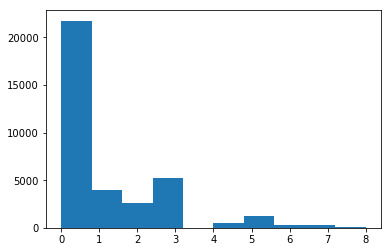

In [4]:
import matplotlib.pyplot as plt
y_train_id = np.zeros(y_train.shape[0])
for i in range(y_train.shape[0]):
    y_train_id[i] = action_to_id(y_train[i])
plt.hist(y_train_id)
plt.show()

In [ ]:
from utils import *
print(action_to_id(y_train[426]))

In [ ]:
y_train[426]

In [ ]:
np.allclose(y_train[426], [0.0, 0.0, 0.2])

In [14]:
np.sum(y_train_id == 8)

126